# Million Song Subset Exploration - Metadata

In the present notebook we perform a first analysis on a subset of the million song dataset.
This subset is available [here](https://labrosa.ee.columbia.edu/millionsong/pages/getting-dataset).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
import sqlite3

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15)
sb.set_palette('Dark2')
sb.set_style('whitegrid')
path = '../MillionSongSubset/'

# Reading SQL tables

For this demo the database ``.db`` file is in a separate folder named ``AdditionalFiles/``.
An alternative to the lines below is a demo available at https://labrosa.ee.columbia.edu/millionsong/sites/default/files/tutorial1.py.txt that was tailored specifically for reading these files.

In [2]:
con_meta = sqlite3.connect(path+'AdditionalFiles/subset_track_metadata.db')
cur_meta = con_meta.cursor()

In [3]:
# subset_track_metadata.db
res = con_meta.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

songs


# Exploring the Metadata tables

The _metadata_ dataset contains basic information about the artist name, song title and album name, year of release but also a measure of _hotness_ and _familiarity_ :
* The _familiarity_ quantifies how well an artist is know at the time of the song release.
* The _hotness_ is a measure of the popularity at the time of the song release.

What kind of insight can we find in there ?

In [4]:
# I this cell we load the dataset in a pandas.DataFrame omitting entries without year information
songs = pd.read_sql_query('SELECT * FROM songs WHERE year!=0', con_meta)
songs.head(5)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001
1,TRACCMH128F428E4CD,No Quieras Marcharte,SOGDQZK12A8C13F37C,Adelante,AR2PT4M1187FB55B1A,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,191.68608,0.561590,0.420570,1984
2,TRACCVS12903D014F8,Ad Te Clamamus Exsvles Mortva Liberi,SOHCCIA12AC907577F,Pentagrammaton,ARZEWUR1187FB53DC8,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,89.15546,0.593416,0.395710,2010
3,TRACCKS128F42B77AE,Murder One,SOBOAQC12A8C13E3E9,BTNHRESURRECTION,ARUZRFN1187B98AC05,2fa45bbb-0efb-4950-9d40-94bf23cbfec1,Bone Thugs-N-Harmony,255.73832,0.815923,0.555138,2000
4,TRACCJA128F149A144,Segredo,SODPNJR12A6D4FA52D,Joao Voz E Violato,AR3THYK1187B999F1F,286ec4c2-b5ca-4f85-b331-280a6d73dd14,João Gilberto,197.19791,0.645192,0.471224,2000


In [5]:
# Then we simply display a couple of information to know
# which kind of data we are dealing with and check potential NaN values
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4680 entries, 0 to 4679
Data columns (total 11 columns):
track_id              4680 non-null object
title                 4680 non-null object
song_id               4680 non-null object
release               4680 non-null object
artist_id             4680 non-null object
artist_mbid           4680 non-null object
artist_name           4680 non-null object
duration              4680 non-null float64
artist_familiarity    4680 non-null float64
artist_hotttnesss     4680 non-null float64
year                  4680 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 402.3+ KB


## Songs per year/artist/album

In [6]:
# Number of songs per year in the subsample
songs_per_yr = songs.year.value_counts()[songs.year.value_counts().index > 1954].sort_index()
songs_per_yr.tail(11)

2000    192
2001    217
2002    198
2003    254
2004    270
2005    304
2006    320
2007    285
2008    253
2009    250
2010     64
Name: year, dtype: int64

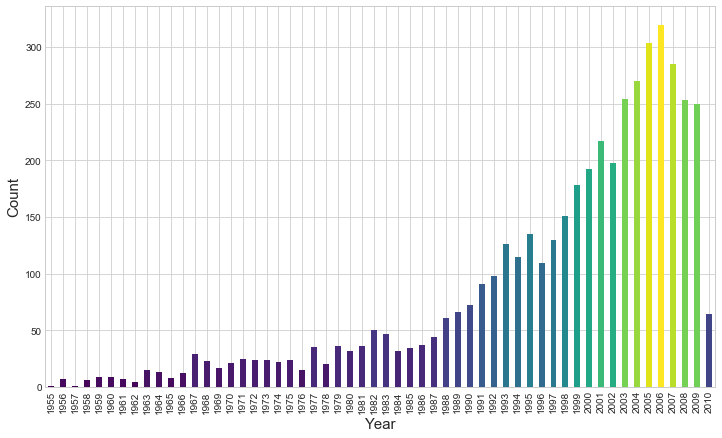

In [7]:
# Visualizing the number of songs per year
l_col = songs_per_yr / songs_per_yr.max()
songs_per_yr.plot.bar(color=cm.viridis(l_col), figsize=(12,7))

plt.xlabel('Year')
plt.ylabel('Count');

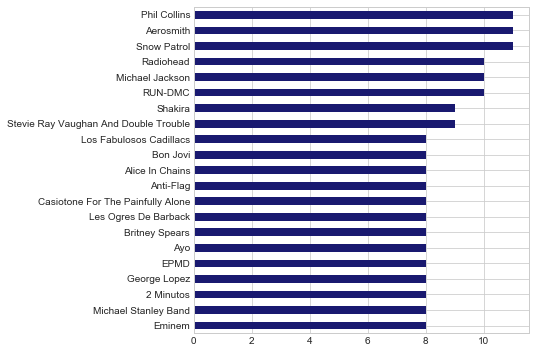

In [8]:
# Counting the number of entry per artist
songs_per_artist = songs.artist_name.value_counts()
songs_per_artist[songs_per_artist >= 8].sort_values().plot.barh(color='midnightblue', figsize=(6,6));

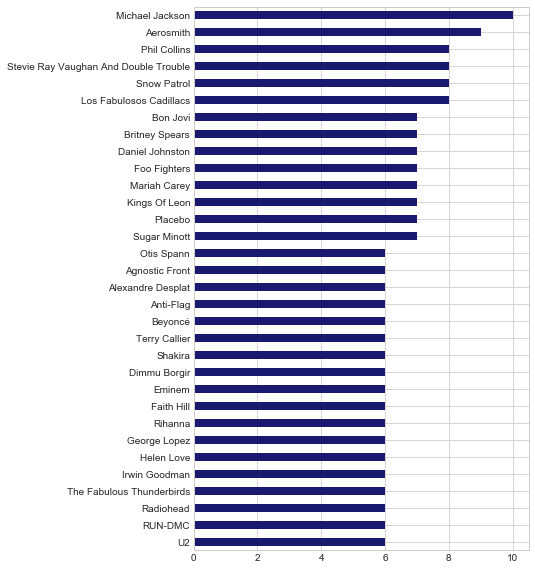

In [9]:
# Number of different albums release per artist
songs_per_art_and_rel = songs.groupby(['artist_name']).release.nunique()
songs_per_art_and_rel[songs_per_art_and_rel >= 6].sort_values().plot.barh(color='midnightblue', figsize=(6,10))
plt.ylabel('');

## Songs Duration

In [10]:
songs.duration.describe()

count    4680.000000
mean      238.781146
std       101.345438
min         1.044440
25%       181.152200
50%       227.382400
75%       278.406080
max      1598.197100
Name: duration, dtype: float64

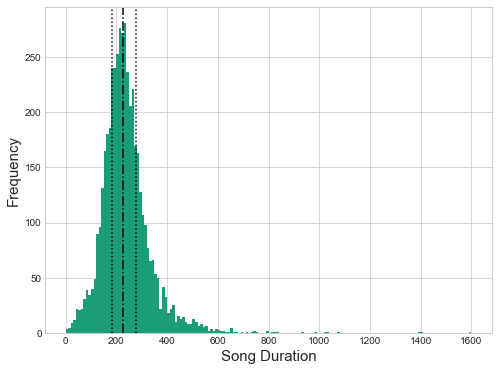

In [11]:
songs.duration.plot.hist(bins=np.arange(0.0, 1610.0, 10.0))
plt.axvline(181.1522, linestyle=':', c='k')
plt.axvline(227.3824, linestyle='-.', c='k')
plt.axvline(278.40608, linestyle=':', c='k')
plt.xlabel('Song Duration');

## Songs Hotness and Familiarity

In [12]:
songs[['artist_hotttnesss','artist_familiarity']].describe()

,artist_hotttnesss,artist_familiarity
count,4680.000000,4680.000000
mean,0.441711,0.631585
std,0.128043,0.140808
min,0.000000,0.000000
25%,0.366820,0.540750
50%,0.420938,0.622875
75%,0.511054,0.727230
max,1.082503,1.000000


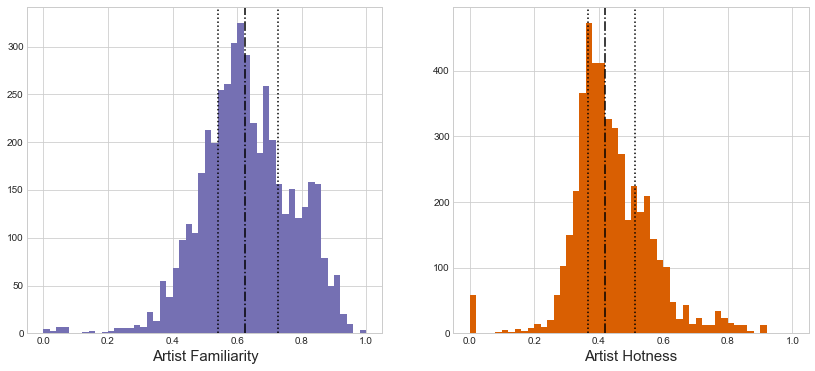

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharex=True)

songs.artist_familiarity.hist(bins=np.linspace(0.0,1.0,51), ax=ax[0], color='C2');
ax[0].set_xlabel('Artist Familiarity')
ax[0].axvline(0.54075, linestyle=':', c='k')
ax[0].axvline(0.622875, linestyle='-.', c='k')
ax[0].axvline(0.72723, linestyle=':', c='k')

songs.artist_hotttnesss.hist(bins=np.linspace(0.0,1.0,51), ax=ax[1], color='C1');
ax[1].set_xlabel('Artist Hotness')
ax[1].axvline(0.36682, linestyle=':', c='k')
ax[1].axvline(0.420938, linestyle='-.', c='k')
ax[1].axvline(0.511054, linestyle=':', c='k');

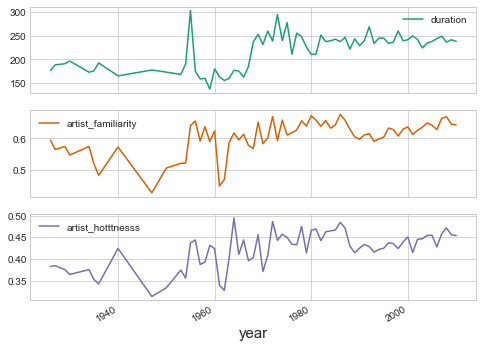

In [14]:
tmp = songs.groupby('year').mean()
tmp.plot(subplots=True);

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


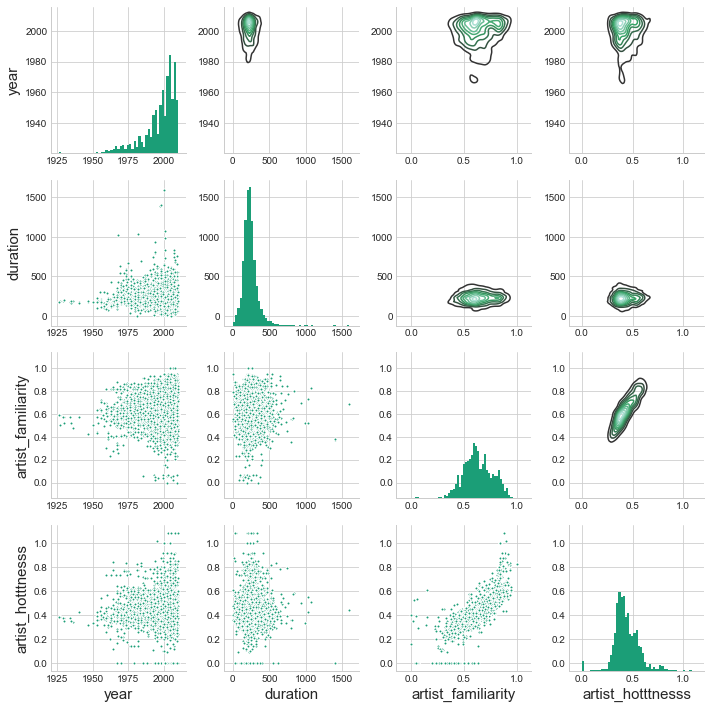

In [15]:
g = sb.PairGrid(songs, vars=['year','duration','artist_familiarity','artist_hotttnesss'])
g.map_upper(sb.kdeplot)
g.map_lower(plt.scatter, marker='.', edgecolor='w')
g.map_diag(plt.hist, bins=51);

## Artist hotness vs Artist familiarity

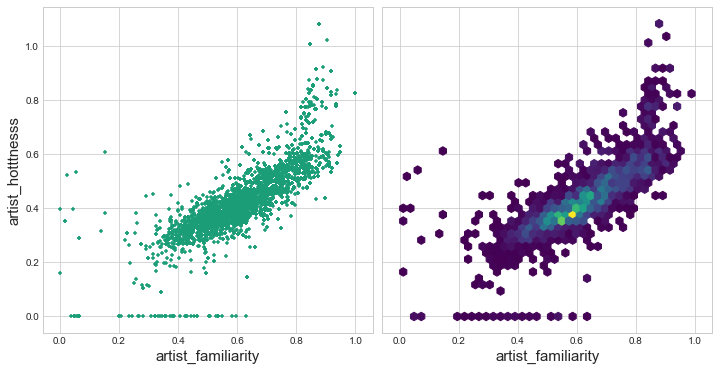

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(12,6))

songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', marker='+', ax=ax[0])
songs.plot.hexbin(x='artist_familiarity', y='artist_hotttnesss', ax=ax[1],
                  gridsize=41, mincnt=1.0, cmap='viridis', colorbar=False)

plt.subplots_adjust(wspace=0.03);

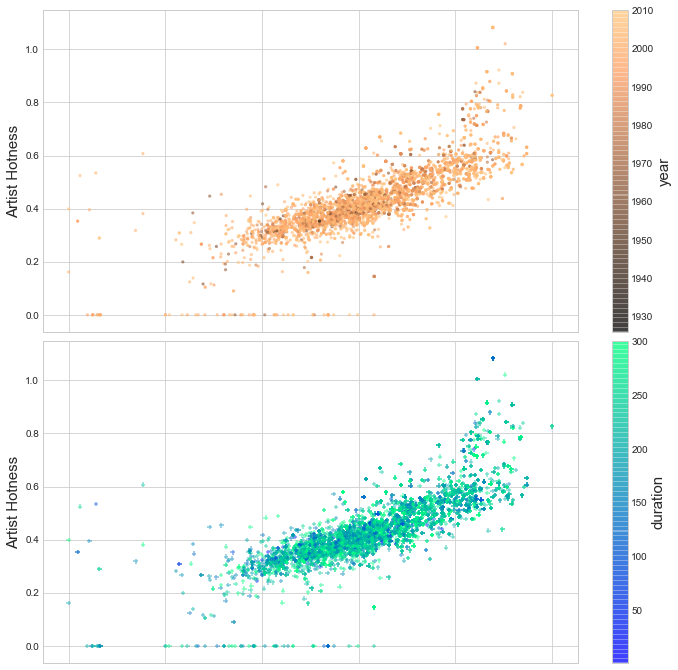

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True,
                       figsize=(12,12))

songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', c='year',
                   marker='.', ax=ax[0], cmap='copper', alpha=0.5)
ax[0].set_ylabel('Artist Hotness')

songs.plot.scatter(x='artist_familiarity', y='artist_hotttnesss', c='duration',
                   marker='+', ax=ax[1], cmap='winter', vmax=300, alpha=0.5)
ax[1].set_xlabel('Artist Familiarity')
ax[1].set_ylabel('Artist Hotness')

plt.subplots_adjust(hspace=0.03);

# Familiarity vs Hotness Clustering

In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [19]:
songs_cl = songs[songs.artist_hotttnesss != 0.0][['artist_familiarity','artist_hotttnesss']]

In [94]:
scores_n = []

for i in range(2,12):
    print('number of clusters : {}'.format(i))
    gmm = GaussianMixture(n_components=i, covariance_type='full')
    bic, aic, log = 0.0, 0.0, 0.0
    for j in range(7):
        gmm.fit(songs_cl)
        bic += gmm.bic(songs_cl)
        aic += gmm.aic(songs_cl)
        log += gmm.score(songs_cl)
    scores_n.append([np.mean(bic), np.mean(aic), np.mean(log)])
    
scores_n = np.asarray(scores_n)

number of clusters : 2
number of clusters : 3
number of clusters : 4
number of clusters : 5
number of clusters : 6
number of clusters : 7
number of clusters : 8
number of clusters : 9
number of clusters : 10
number of clusters : 11


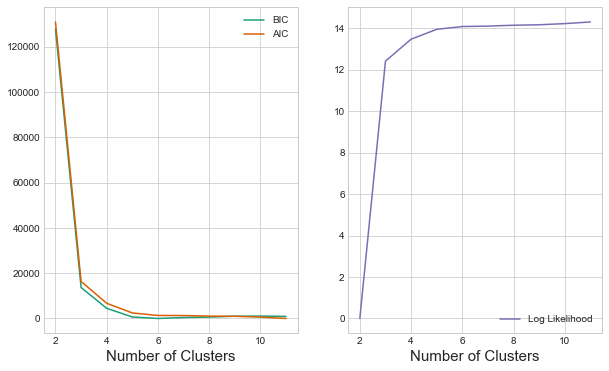

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,6))

ax[0].plot(range(2,12), scores_n[:,0] - np.min(scores_n[:,0]), 'C0')
ax[0].plot(range(2,12), scores_n[:,1] - np.min(scores_n[:,1]), 'C1')
ax[0].legend(['BIC','AIC'])
ax[0].set_xlabel('Number of Clusters')

ax[1].plot(range(2,12), scores_n[:,2] - np.min(scores_n[:,2]), 'C2')
ax[1].legend(['Log Likelihood'])
ax[1].set_xlabel('Number of Clusters');

In [22]:
gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(songs_cl)
gmm_pred = gmm.predict_proba(songs_cl)

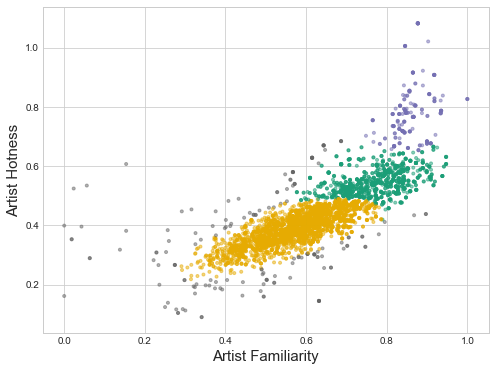

In [96]:
plt.scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=np.argmax(gmm_pred, axis=1),
            marker='.', alpha=0.5, cmap='Dark2_r')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');

In [24]:
new_pred = np.argmax(gmm_pred, axis=1).copy()

for i in range(4):
    grp_mean = songs_cl.artist_familiarity[new_pred==i].mean()
    if (grp_mean > 0.5) and (grp_mean < 0.8):
        new_pred[new_pred==i] = 4
        
songs_cl['gmm'] = new_pred

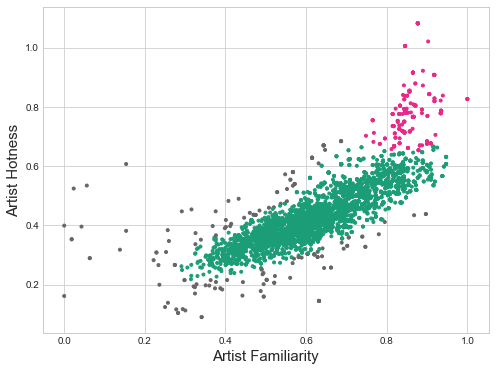

In [97]:
plt.scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=new_pred,
            marker='.', cmap='Dark2_r')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');

In [61]:
agg = AgglomerativeClustering(n_clusters=3, linkage='average')
agg_pred = agg.fit_predict(songs_cl)
songs_cl['agglomerative'] = agg_pred

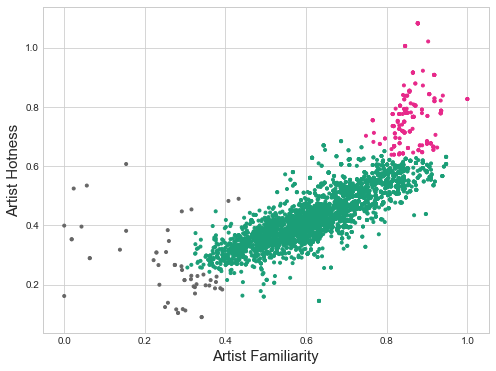

In [98]:
plt.scatter(songs_cl.artist_familiarity, songs_cl.artist_hotttnesss, c=agg_pred,
            marker='.', alpha=1.0, cmap='Dark2_r')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');

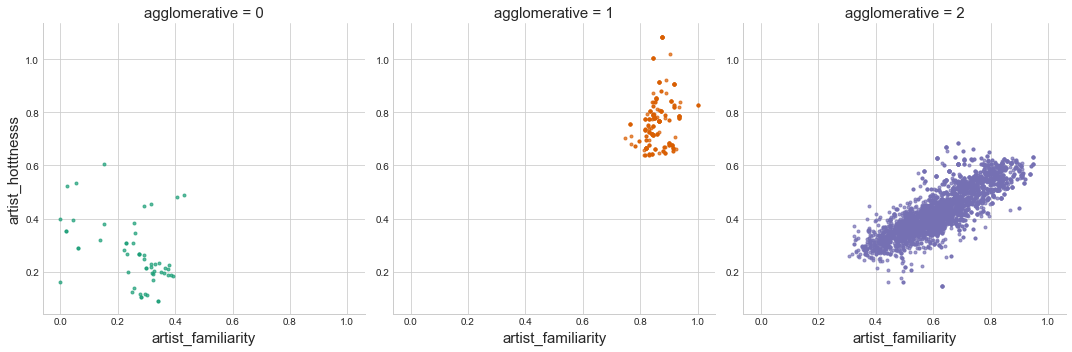

In [104]:
sb.lmplot(data=songs_cl, x='artist_familiarity', y='artist_hotttnesss',
          hue='agglomerative', col='agglomerative',
          fit_reg=False, markers='.', scatter_kws={'alpha':0.7});

## Linear Regression of the Clustering

Using the agglomerative clustering result.

In [91]:
songs_linreg = np.polyfit(songs_cl.artist_familiarity[songs_cl.agglomerative == 2].values,
                          songs_cl.artist_hotttnesss[songs_cl.agglomerative == 2].values, 1)
print("Linear Regression of the 'main sequence' :\n\
Hotness = {:.2f} * Familiarity + {:.2f}".format(songs_linreg[0],songs_linreg[1]))

Linear Regression of the 'main sequence' :
Hotness = 0.59 * Familiarity + 0.06


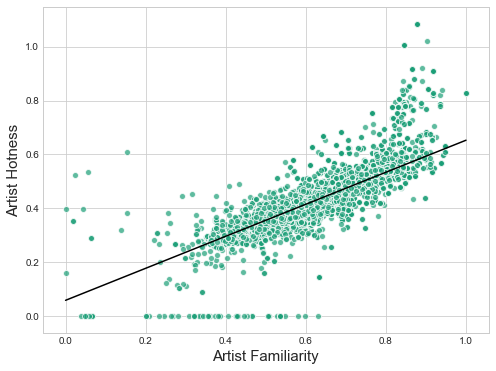

In [100]:
plt.scatter(songs.artist_familiarity, songs.artist_hotttnesss,
            marker='o', edgecolors='w', cmap='Dark2_r', alpha=0.7)
plt.plot([0.0,1.0], [0.0,songs_linreg[0]] + songs_linreg[1], 'k')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotness');